# Understanding Convolutional Neural Networks
This notebook will guide you through the use of the `keras` package to train convolutional neural networks for handwritten digit classification and will propose a series of visualization tools, based on filter activation statistics, to better understand how the CNN is accomplishing its task. 

## Loading the packages

In [1]:
import numpy as np
from matplotlib import pyplot as pl

from keras.datasets import mnist
from keras.models import Model
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Input
from sklearn import metrics as me
from scipy import stats

%matplotlib inline

Using TensorFlow backend.


First, create some useful functions

In [32]:
def build_grid_of_images(array):
    assert len(array.shape) == 3
    array = np.rollaxis(array, 2, 0)
    dim_0 = np.sqrt(array.shape[0])
    assert dim_0.is_integer()
    dim_0 = int(dim_0)
    
    temp_out = np.reshape(array, (dim_0, dim_0, array.shape[1], array.shape[2]))
    temp_out = np.rollaxis(temp_out, 1, 3)
    return np.reshape(temp_out, (dim_0*array.shape[1], dim_0*array.shape[2]))

#a = np.array(np.arange(36))
#print a

#b = np.reshape(a, (4,3,3))
#print b[0,:,:]
#print b[1,:,:]

#c = build_grid_of_images(b)
#print c

def plot_conv_layer_output(temp_out, title):
    temp_to_plot = build_grid_of_images(temp_out)
    pl.imshow(temp_to_plot, interpolation='nearest', cmap=pl.get_cmap('Greys'))
    ax = pl.gca()
    ax.set_xticks(np.arange(-0.5, temp_to_plot.shape[0]+0.5, temp_out.shape[0]))    
    ax.set_yticks(np.arange(-0.5, temp_to_plot.shape[0]+0.5, temp_out.shape[1]))
    pl.grid()
    pl.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
    pl.title(title)

def plot_dense_layer_output(temp_out, title):
    pl.bar(np.arange(temp_out.shape[1])-0.4, temp_out[0,:])
    pl.xlim(-0.5, temp_out.shape[1])
    pl.grid()
    pl.title(title)

Load the `mnist` dataset and normalize in the range [0, 1]

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print n_train, 'train samples'
print n_test, 'test samples'

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

60000 train samples
10000 test samples


Create the CNN and show its architecture

In [7]:
l0 = Input(shape=(height, width, 1), name='l0')

l1 = Convolution2D(9, (5, 5), padding='same', activation='relu', name='l1')(l0)
l1_mp = MaxPooling2D(pool_size=(2, 2), name='l1_mp')(l1)

l2 = Convolution2D(9, (5, 5), padding='same', activation='relu', name='l2')(l1_mp)
l2_mp = MaxPooling2D(pool_size=(2, 2), name='l2_mp')(l2)

l3 = Convolution2D(16, (3, 3), padding='same', activation='relu', name='l3')(l2_mp)
l3_mp = MaxPooling2D(pool_size=(2, 2), name='l3_mp')(l3)

flat = Flatten(name='flat')(l3_mp)

l4 = Dense(25, activation='relu', name='l4')(flat)

l5 = Dense(n_classes, activation='softmax', name='l5')(l4)

model = Model(inputs=l0, outputs=l5)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
l0 (InputLayer)              (None, 28, 28, 1)         0         
_________________________________________________________________
l1 (Conv2D)                  (None, 28, 28, 9)         234       
_________________________________________________________________
l1_mp (MaxPooling2D)         (None, 14, 14, 9)         0         
_________________________________________________________________
l2 (Conv2D)                  (None, 14, 14, 9)         2034      
_________________________________________________________________
l2_mp (MaxPooling2D)         (None, 7, 7, 9)           0         
_________________________________________________________________
l3 (Conv2D)                  (None, 7, 7, 16)          1312      
_________________________________________________________________
l3_mp (MaxPooling2D)         (None, 3, 3, 16)          0         
__________

Define some constants and train de CNN

In [8]:
batch_size = 256
n_epoch = 10

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epoch, verbose=1, validation_data=(X_test, Y_test))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 18s - loss: 0.4948 - acc: 0.8499 - val_loss: 0.1956 - val_acc: 0.9380
Epoch 2/10
60000/60000 [==============================] - 17s - loss: 0.1529 - acc: 0.9528 - val_loss: 0.1323 - val_acc: 0.9539
Epoch 3/10
60000/60000 [==============================] - 17s - loss: 0.1015 - acc: 0.9677 - val_loss: 0.0762 - val_acc: 0.9760
Epoch 4/10
60000/60000 [==============================] - 17s - loss: 0.0792 - acc: 0.9747 - val_loss: 0.0592 - val_acc: 0.9835
Epoch 5/10
60000/60000 [==============================] - 17s - loss: 0.0667 - acc: 0.9789 - val_loss: 0.0522 - val_acc: 0.9844
Epoch 6/10
60000/60000 [==============================] - 17s - loss: 0.0579 - acc: 0.9814 - val_loss: 0.0914 - val_acc: 0.9701
Epoch 7/10
60000/60000 [==============================] - 17s - loss: 0.0508 - acc: 0.9842 - val_loss: 0.0528 - val_acc: 0.9829
Epoch 8/10
60000/60000 [==============================

Show the performance of the model

('Test score:', 0.03850674789993791)
('Test accuracy:', 0.9879)


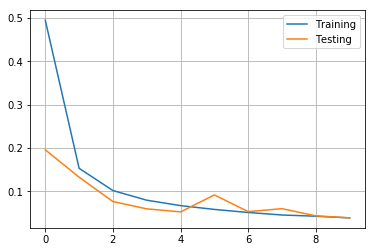

In [9]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Confusion matrix

In [11]:
pred = model.predict_on_batch(X_test)
pred = np.argmax(pred, axis=-1)
me.confusion_matrix(y_test, pred)

array([[ 962,    0,    1,    1,    3,    2,    4,    3,    3,    1],
       [   0, 1132,    0,    3,    0,    0,    0,    0,    0,    0],
       [   1,    3, 1013,    6,    1,    0,    0,    6,    2,    0],
       [   0,    0,    0, 1001,    0,    3,    0,    2,    4,    0],
       [   0,    0,    0,    0,  976,    0,    1,    0,    2,    3],
       [   1,    0,    0,    5,    0,  883,    1,    1,    0,    1],
       [   5,    2,    0,    0,    2,    6,  943,    0,    0,    0],
       [   0,    3,    2,    2,    0,    0,    0, 1014,    2,    5],
       [   1,    0,    1,    1,    0,    2,    0,    0,  968,    1],
       [   2,    1,    0,    1,    7,    3,    0,    3,    5,  987]])

## Testing the behaviour of each layer

Artificial neural networks are considered black-box models in which it is very difficult to understand the meaning of the model parameters (weights).
The following cells show some approaches which should ease the understanding of how a CNN works, or what kind of features are encoded in the internal filters of the network

In [13]:
l1_o = Model(inputs=l0, outputs=l1)
l1_mp_o = Model(inputs=l0, outputs=l1_mp)
l2_o = Model(inputs=l0, outputs=l2)
l2_mp_o = Model(inputs=l0, outputs=l2_mp)
l3_o = Model(inputs=l0, outputs=l3)
l3_mp_o = Model(inputs=l0, outputs=l3_mp)
flat_o = Model(inputs=l0, outputs=flat)
l4_o = Model(inputs=l0, outputs=l4)
l5_o = Model(inputs=l0, outputs=l5)

Do the test with one input from the test set

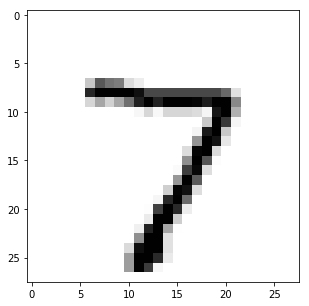

In [15]:
current_input = X_test[0:1,:,:,0:1]
pl.figure(figsize=(5,5))
pl.imshow(current_input[0,:,:,0], interpolation='nearest', cmap=pl.get_cmap('Greys'))

### Visualize the output of each layer

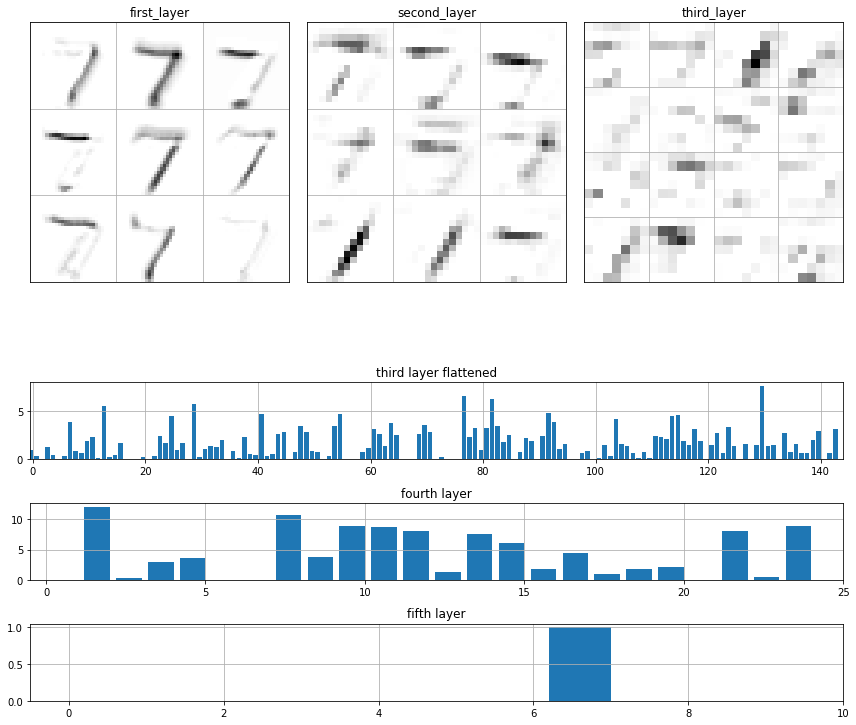

In [33]:
pl.figure(figsize=(12,10))

pl.subplot(2,3,1)
temp_out = l1_o.predict(current_input)[0,:,:,:]
plot_conv_layer_output(temp_out, 'first_layer')

pl.subplot(2,3,2)
temp_out = l2_o.predict(current_input)[0,:,:,:]
plot_conv_layer_output(temp_out, 'second_layer')

pl.subplot(2,3,3)
temp_out = l3_o.predict(current_input)[0,:,:,:]
plot_conv_layer_output(temp_out, 'third_layer')

pl.subplot(6,1,4)
temp_out = flat_o.predict(current_input)
plot_dense_layer_output(temp_out, 'third layer flattened')

pl.subplot(6,1,5)
temp_out = l4_o.predict(current_input)
plot_dense_layer_output(temp_out, 'fourth layer')

pl.subplot(6,1,6)
temp_out = l5_o.predict(current_input)
plot_dense_layer_output(temp_out, 'fifth layer')

pl.tight_layout()

For a given input image, the previous cell shows how the different filters of the network generate internal representations of the input image. The first layers are easier to interpret since they contain more spatial information (e.g., edges or blobs). On the other hand, deeper layers (fourth layer) are more difficult to understand because the spatial information and the salient details of the different classes are encoded in the internal representation of the network.

### Visualize the average output of each layer
Let's do the same for the whole set of training images and then compute the average activation of each layer

In [40]:
all_l1 = l1_o.predict(X_train)
all_l1_by_class = np.zeros((n_classes,) + all_l1.shape[1:4])
for i in np.arange(n_classes):
    all_l1_by_class[i,:,:,:] = np.mean(all_l1[Y_train[:,i] == 1.0], axis=0)

all_l2 = l2_o.predict(X_train)
all_l2_by_class = np.zeros((n_classes,) + all_l2.shape[1:4])
for i in np.arange(n_classes):
    all_l2_by_class[i,:,:,:] = np.mean(all_l2[Y_train[:,i] == 1.0], axis=0)

all_l3 = l3_o.predict(X_train)
all_l3_by_class = np.zeros((n_classes,) + all_l3.shape[1:4])
for i in np.arange(n_classes):
    all_l3_by_class[i,:,:,:] = np.mean(all_l3[Y_train[:,i] == 1.0], axis=0)

Visualize the average activation of each layer per class

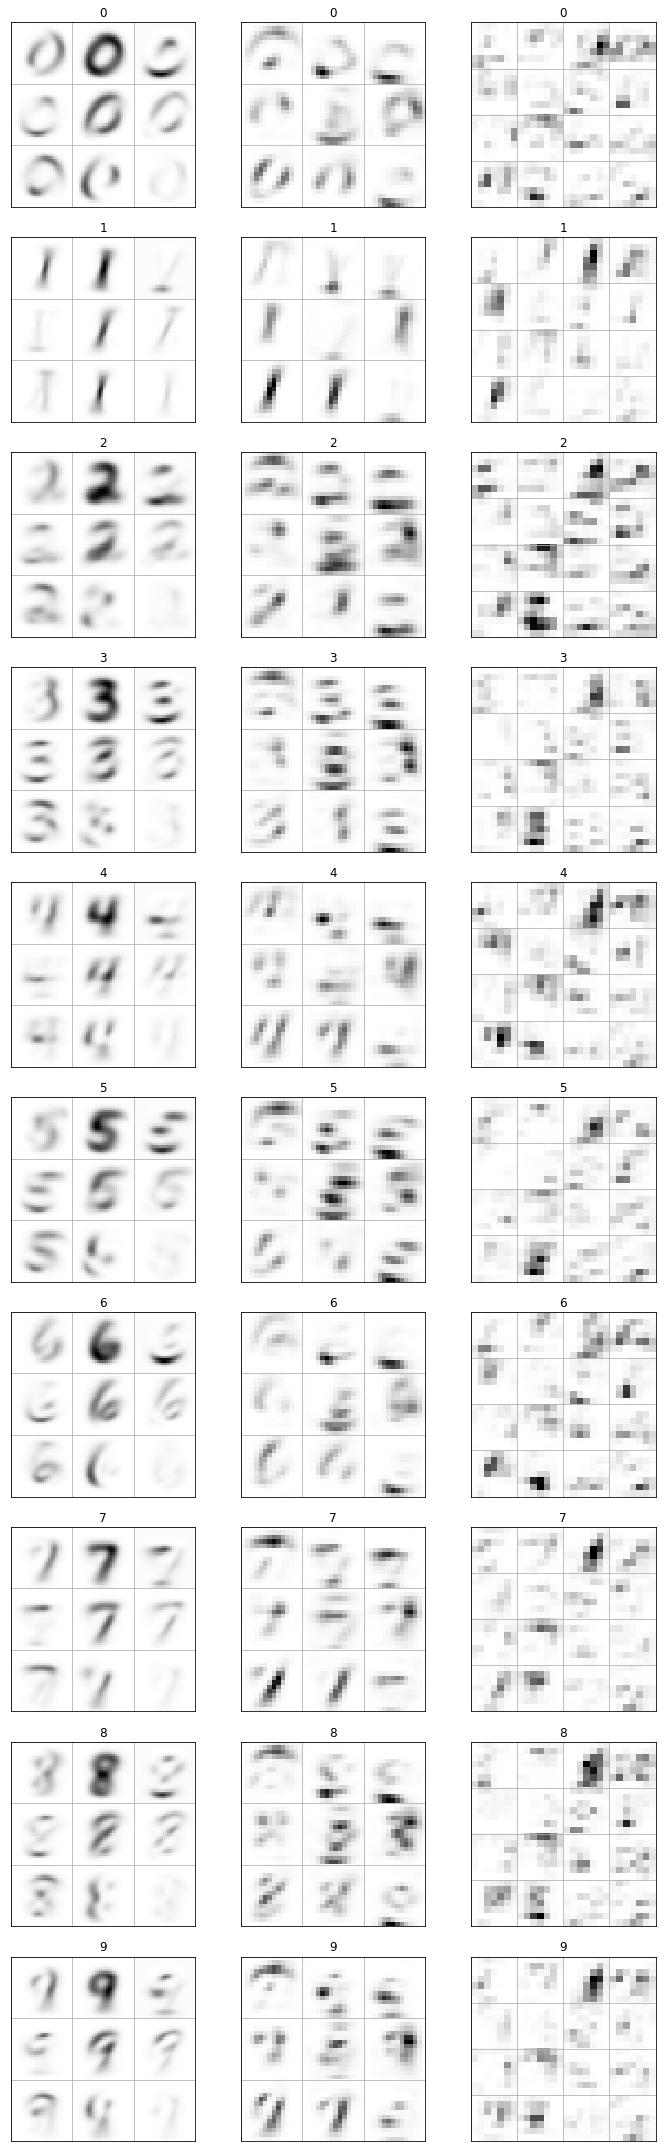

In [41]:
pl.figure(figsize=(10,30))
for i in np.arange(n_classes):
    pl.subplot(10,3,3*i+1)
    plot_conv_layer_output(all_l1_by_class[i,:,:,:], str(i))
    pl.subplot(10,3,3*i+2)
    plot_conv_layer_output(all_l2_by_class[i,:,:,:], str(i))
    pl.subplot(10,3,3*i+3)
    plot_conv_layer_output(all_l3_by_class[i,:,:,:], str(i))
pl.tight_layout()

### Visualize which filter is activated most of the time for each pixel
The following cells find the index of the filter with the highest activation, and then compute the mode through the whole dataset

In [43]:
l1_f = np.zeros((n_classes, ) + all_l1.shape[1:3])
for i in np.arange(n_classes):
    temp = np.argmax(all_l1[Y_train[:,i] == 1.0], axis=3)
    l1_f[i,:,:] = stats.mode(temp, axis=0)[0]
l2_f = np.zeros((n_classes,) + all_l2.shape[1:3])
for i in np.arange(n_classes):
    temp = np.argmax(all_l2[Y_train[:,i] == 1.0], axis=3)
    l2_f[i,:,:] = stats.mode(temp, axis=0)[0]
l3_f = np.zeros((n_classes,) + all_l3.shape[1:3])
for i in np.arange(n_classes):
    temp = np.argmax(all_l3[Y_train[:,i] == 1.0], axis=3)
    l3_f[i,:,:] = stats.mode(temp, axis=0)[0]

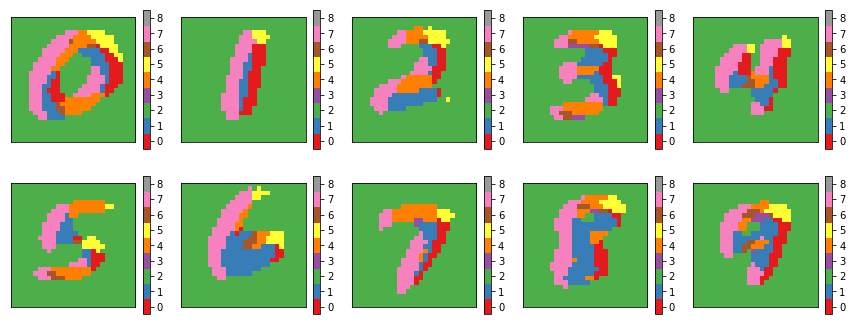

In [46]:
pl.figure(figsize=(12,5))
for i in np.arange(n_classes):
    pl.subplot(2,5,i+1)
    pl.imshow(l1_f[i], interpolation='nearest', cmap=pl.get_cmap('Set1', all_l1.shape[3]), vmin=0, vmax=all_l1.shape[3]-1)
    pl.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
    pl.colorbar(values=np.arange(all_l1.shape[3]),
                boundaries=np.arange(all_l1.shape[3]+1)-0.5,
                ticks=np.arange(all_l1.shape[3]), shrink=0.8)
pl.tight_layout()

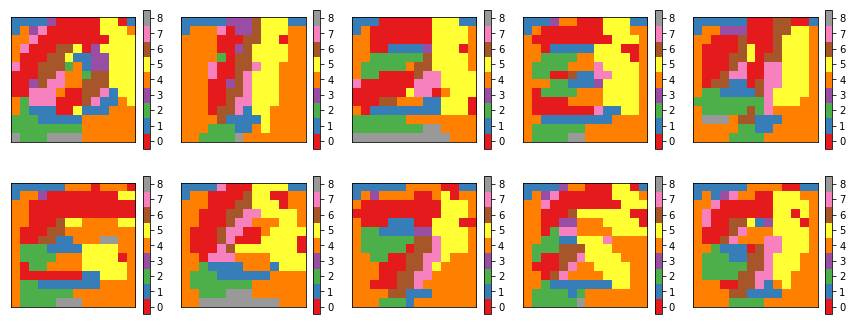

In [47]:
pl.figure(figsize=(12,5))
for i in np.arange(n_classes):
    pl.subplot(2,5,i+1)
    pl.imshow(l2_f[i], interpolation='nearest', cmap=pl.get_cmap('Set1', all_l2.shape[3]), vmin=0, vmax=all_l2.shape[3]-1)
    pl.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
    pl.colorbar(values=np.arange(all_l2.shape[3]),
                boundaries=np.arange(all_l2.shape[3]+1)-0.5,
                ticks=np.arange(all_l2.shape[3]), shrink=0.8)
pl.tight_layout()

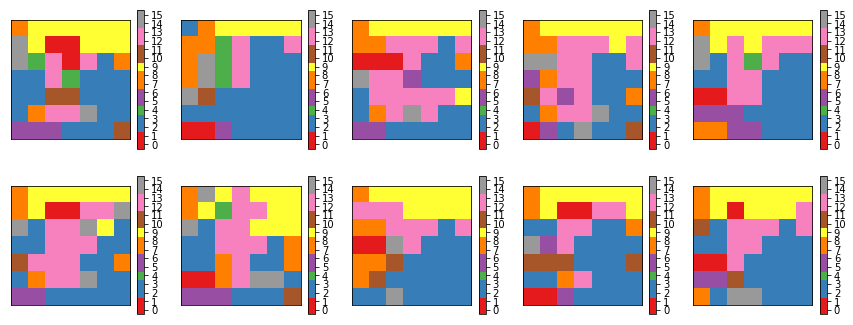

In [48]:
pl.figure(figsize=(12,5))
for i in np.arange(n_classes):
    pl.subplot(2,5,i+1)
    pl.imshow(l3_f[i], interpolation='nearest', cmap=pl.get_cmap('Set1', all_l3.shape[3]), vmin=0, vmax=all_l3.shape[3]-1)
    pl.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
    pl.colorbar(values=np.arange(all_l3.shape[3]),
                boundaries=np.arange(all_l3.shape[3]+1)-0.5,
                ticks=np.arange(all_l3.shape[3]), shrink=0.8)
pl.tight_layout()